# Development of WDM modeling in hmf and halomod

In this notebook, I'll go through the implementation of the WDM in `hmf` and `halomod`, showing how things line up with stuff in literature.

## Transfer Function

We implement a general `TransferWDM` class, which should be general enough for any WDM transfer fitting function. At this stage, the only one implemented is `Viel05`, which has the form

$$ T(k) = (1+(\lambda^{fs}_{eff} k)^{2\mu})^{-5/\mu},  $$

where $\mu$ is a parameter of the fit with default $\mu=1.12$, and the effective "free-streaming" scale is

$$\lambda^{fs}_{eff} = 0.045 m_x^{-1.11}\left(\frac{\Omega_c}{0.25}\right)^{0.11}\left(\frac{h}{0.7}\right)^{1.22}\left(\frac{1.5}{g_X}\right)^{0.29}, $$

with $m_x$ the particle mass in keV and $g_X$ a parameter that we leave at 1.5 for now. The effective free-streaming scales introduces a corresponding free-streaming mass:

$$ m_{fs} = \frac{4\pi}{3} \left(\frac{\lambda_{eff}^{fs}}{2}\right)^3 $$

From this transfer function, we can define two "half-mode" scales (where the Transfer function is 1/2) -- a length and mass, as

$$\lambda_{hm} = 2\pi \lambda^{fs}_{eff} \left(2^{\mu/5}-1\right)^{-0.5/\mu} $$ 

and

\begin{equation} 
    m_{hm} = \frac{4\pi}{3}\bar{\rho_0} \left(\frac{\lambda_{\rm hm}}{2}\right)^3.
\end{equation}

Note: all these equations were taken from Schneider et al. 2012.

Let's define a WDM transfer function then:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import contextlib

import hmf
from hmf import MassFunction  # Full mass-function class in CDM
from hmf.alternatives.wdm import (
    MassFunctionWDM,  # Mass Function class in WDM (note all WDM variants just have appended WDM)
    TransferWDM,  # Transfer-function class with WDM modifications
)

import halomod
from halomod import HaloModel

In [3]:
print(f"Using halomod v{halomod.__version__} and hmf v{hmf.__version__}")

Using halomod v2.2.2.dev9+gc49b3b6.d20240820 and hmf v3.5.0


In [4]:
wdm_transfer = TransferWDM(
    transfer_params={"extrapolate_with_eh": True}
)  # Default Planck15 cosmology and m_x = 3keV

Now print the values of the free-streaming and half-mode scales. The half-mode scale is where we expect the mass function to be first affected by the WDM.

In [5]:
wdm_transfer.update(wdm_mass=1)

This puts the half-mode mass at roughly $10^9 h^{-1}M_\odot$. Compare these numbers to Schneider et al. 2012: <img src="schneider_hm.jpg">.

Now compare the linear matter power spectrum of WDM for a few test masses:

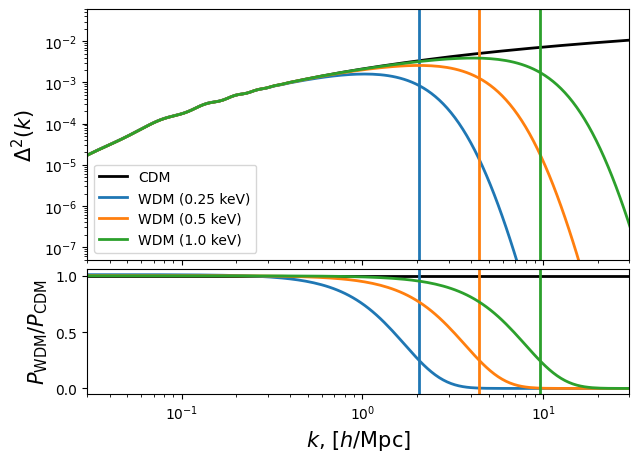

In [6]:
cdm_mf = MassFunction(z=49, transfer_params={"extrapolate_with_eh": True})
wdm_transfer.update(z=49)

fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    subplot_kw={"xscale": "log", "xlim": (0.03, 30)},
    figsize=(7, 5),
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.05},
)

ax[0].plot(cdm_mf.k, cdm_mf.delta_k, label="CDM", lw=2, color="k")
ax[1].plot(cdm_mf.k, np.ones_like(cdm_mf.k), lw=2, color="k")

for i, mx in enumerate([0.25, 0.5, 1.0]):
    wdm_transfer.update(wdm_mass=mx)
    ax[0].plot(wdm_transfer.k, wdm_transfer.delta_k, label=f"WDM ({mx} keV)", lw=2, color=f"C{i}")
    ax[1].plot(wdm_transfer.k, wdm_transfer.delta_k / cdm_mf.delta_k, lw=2, color=f"C{i}")
    ax[0].axvline(2 * np.pi / wdm_transfer.wdm.lam_hm, color=f"C{i}", lw=2)
    ax[1].axvline(2 * np.pi / wdm_transfer.wdm.lam_hm, color=f"C{i}", lw=2)

ax[1].set_xlabel(r"$k$, [$h$/Mpc]", fontsize=15)
ax[0].set_ylim((5e-8, 0.06))

ax[0].set_yscale("log")
ax[1].set_ylabel(r"$P_{\rm WDM}/P_{\rm CDM}$", fontsize=15)
ax[0].set_ylabel(r"$\Delta^2(k)$", fontsize=15)
ax[0].legend(loc=0)

Compare this to the figure from Schneider: <img src="schneider_deltak.jpg">

## Mass Variance

The next thing to calculate is the mass variance, defined as 
$$ \sigma^2(R) = \int k^2 P(k) W(kR)dk, $$
where $W(kR)$ is a *window*/*filter* function in fourier space. 

Usually, people use the top-hat in real space, so that in Fourier-space,
$$ W(y) = \frac{3(\sin y - y \cos y)}{y^3}.$$

With this definition, we get the following plot for $\sigma(m)$, where in the top-hat window function,
$$ m = \frac{4\pi}{3}\bar{\rho}R^3.$$

The behaviour of the normal top-hat window function gives us problems when we consider the mass function. Following Schneider, define the logarithmically binned HMF as

$$ \frac{dn}{d\ln m} = \frac{1}{2}\frac{\bar{\rho}}{m}f(\nu)\left|\frac{d\ln \sigma^2}{d\ln m}\right|, $$

where $\nu = \delta_c^2/\sigma^2$. Then in the small-scale limit, when $R\rightarrow0$, the asymptotic behaviour of the mass function is

$$ \lim_{R\rightarrow 0}\frac{dn}{d\ln m} \propto \frac{1}{R^3} \lim_{R\rightarrow 0} \frac{d \ln \sigma^2}{d \ln m}. $$

For the top-hat function, this goes to $R^{-1}$, and thus diverges. But this contradicts what we expect from WDM, which should not form haloes below $m_{fs}$. If we however use a filter which is a top-hat in $k$-space, we find that the limit becomes 0, which is what we expect. 

So below we plot the mass variance in both CDM and WDM using a top-hat in real and $k$-space.

/home/sgm/work/halos/halomod/.venv/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


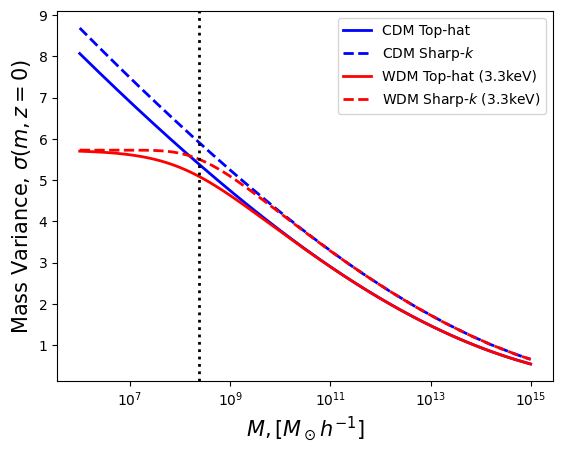

In [7]:
# Unfortunately as it stands have to hack this
with contextlib.suppress(KeyError):
    del cdm_mf.filter_params["c"]

wdm_mf = MassFunctionWDM(wdm_mass=3.3, Mmin=6, filter_model="TopHat")
cdm_mf.update(z=0, Mmin=6, filter_model="TopHat")

plt.plot(cdm_mf.m, cdm_mf.sigma, label="CDM Top-hat", lw=2, color="b")
cdm_mf.update(filter_model="SharpK", filter_params={"c": 2.5})
plt.plot(cdm_mf.m, cdm_mf.sigma, label=r"CDM Sharp-$k$", lw=2, ls="--", color="b")

plt.plot(wdm_mf.m, wdm_mf.sigma, label="WDM Top-hat (3.3keV)", lw=2, color="r")
wdm_mf.update(filter_model="SharpK", filter_params={"c": 2.5})
plt.plot(wdm_mf.m, wdm_mf.sigma, label=r"WDM Sharp-$k$ (3.3keV)", lw=2, ls="--", color="r")

plt.axvline(wdm_mf.wdm.m_hm, ls=":", lw=2, color="k")
plt.ylabel(r"Mass Variance, $\sigma(m,z=0)$", fontsize=15)
plt.xlabel(r"$M, [M_\odot h^{-1}]$", fontsize=15)
plt.legend(loc=0)
plt.xscale("log");

We see that in the WDM case, the mass variance asymptotes to a constant at low mass, because the integral is truncated. Compare to Benson+12: <img src="benson_sigma.jpg">.

Note the differences probably arise due to different cosmology and particle mass. 

See also Bose+15: <img src="bose_sigma.jpg">


## Mass Function with Sharp-K

We have 

$$ \frac{dW}{d \log y} = -y \delta^D(1-y), $$

where $\delta^D$ is the dirac delta function. Then we can solve the last factor of the mass function as

$$ \frac{d \ln \sigma^2}{d \ln R}  -\frac{1}{2\pi^2 \sigma^2}\frac{P(1/R)}{R}, $$

so that

$$ \frac{dn}{d\ln m} = -\frac{1}{2} \frac{\bar{\rho}}{m} f(\nu) \frac{d\ln \sigma^2}{d \ln R}\frac{d \ln R}{d \ln M}, $$

where the last factor is 3 if we assume that $m \propto R^3$ (which we do). In this case, however, there is still no clear way to assign mass to the filter scale, and so we adopt a parameterisation

$$ m = \frac{4\pi}{3}\bar{\rho} [c R]^3 $$

where we are free to choose $c$ so as to best-fit our data. Schneider+12 chooses a value of $c=2.7$, whereas Benson chooses $c=2.5$, along with Bose+15 and Schneider+14, and Lacey and Cole choose $c=2.42$. We leave this parameter to be set by the user, with default $c=2.5$.

Schneider et al. also found that the parameter $q$ in the usual ST functional form was no longer necessary, due to the arbitrary $c$. We leave this to be optional in the base code, but set it everywhere here. We could conversely choose to leave $q$ as 0.707 and use a re-mapping of the barrier crossing parameter $\delta_c$ as in Benson+12.

Note that one can make ellipsoidal corrections as well, but we don't do that, on advice from Aurel Schneider himself.


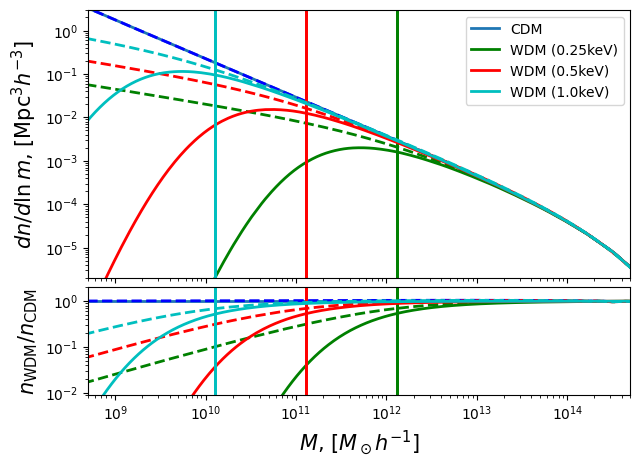

In [8]:
# Create/update correct instances
cdm_mf_th = MassFunction(hmf_model="SMT", Mmin=6.0, z=0)  # ,fsig_params={"a":1}
cdm_mf.update(
    hmf_model="SMT",
    Mmin=6.0,
    z=0,
    hmf_params={"a": 1},
    filter_model="SharpK",
    filter_params={"c": 2.5},
)
wdm_mf_th = MassFunctionWDM(hmf_model="SMT", Mmin=6.0, z=0)  # ,fsig_params={"a":1}
wdm_mf.update(
    hmf_model="SMT", hmf_params={"a": 1}, Mmin=6.0, filter_model="SharpK", filter_params={"c": 2.5}
)

fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    subplot_kw={"xscale": "log", "xlim": (5e8, 5e14), "yscale": "log"},
    gridspec_kw={"height_ratios": [2.5, 1]},
    figsize=(7, 5),
)
ax[0].plot(cdm_mf.m, cdm_mf.dndlnm, label="CDM", lw=2)
ax[1].plot(cdm_mf.m, np.ones_like(cdm_mf.m), lw=2)
ax[0].plot(cdm_mf_th.m, cdm_mf.dndlnm, ls="--", color="b", lw=2)
ax[1].plot(cdm_mf_th.m, cdm_mf_th.dndlnm / cdm_mf.dndlnm, ls="--", color="b", lw=2)
cols = ["g", "r", "c"]
for j, mx in enumerate([0.25, 0.5, 1.0]):
    for i, fil in enumerate([wdm_mf, wdm_mf_th]):
        label = None
        if i == 0:
            label = f"WDM ({mx}keV)"
        ls = ["-", "--"][i]

        fil.update(wdm_mass=mx)

        ax[0].plot(fil.m, fil.dndlnm, ls=ls, color=cols[j], label=label, lw=2)
        ax[1].plot(fil.m, fil.dndlnm / cdm_mf.dndlnm, ls=ls, color=cols[j], lw=2)
        ax[0].axvline(wdm_mf.wdm.m_hm, color=cols[j], lw=2)
        ax[1].axvline(wdm_mf.wdm.m_hm, color=cols[j], lw=2)

ax[1].set_xlabel(r"$M$, $[M_\odot h^{-1}]$", fontsize=15)
ax[0].set_ylim((2e-6, 3))
ax[1].set_ylabel(r"$n_{\rm WDM}/n_{\rm CDM}$", fontsize=15)
ax[0].set_ylabel(r"$dn/d \ln m$, [${\rm Mpc}^3h^{-3}$]", fontsize=15)
ax[1].set_ylim((0.009, 2.0))
plt.subplots_adjust(hspace=0.05)
ax[0].legend(loc=0);

Note that in this plot, the top-hat curves (dashed) have $q=0.707$, while the sharp-$k$ curves (solid) have $q=1$. This gives an excellent fit at high mass, and correct behaviour at low mass. 

And compare this to Schneider 2013 (HMF and the Free-Streaming Scale): <img src="schneider_hmf.jpg">

Note that there are other methods of fitting the mass function empirically, which are implemented but we don't use them here. 

## Halo Profile

Schneider+12 find no significant difference between profiles in WDM and CDM, and so remain with the NFW profile. In Bose+15 they try both the NFW and Einasto profiles, and conclude that the Einasto fits slightly better. Given the better resolution of the Bose+15 results, we would use them, but they only give a ratio of c_WDM/c_CDM without giving explicitly either c_CDM or c_WDM. Thus as a first dig we use the rescaling method of Bose+15, but with a c_CDM from Duffy, and just the NFW profile.

We can't use the Einasto profile because the concentration definition is different (though the ratio should be pretty similar I would expect...). 

So, anyway, $c(m)$ in Duffy was

$$c(m,z) = \frac{6.71}{(1+z)^{0.44}} \left(\frac{M_\star}{m}\right)^{0.091}, $$

where $\delta_c^2/\sigma^2(M_\star) = 1$. Then the rescaling goes like

$$ \frac{c_{WDM}}{c_{CDM}} = \left(1+\gamma_1 \frac{m_{hm}}{m}\right)^{-\gamma_2} \times (1+z)^{\beta_0 z - \beta_1}, $$

with $\gamma_1=60$, $\gamma_2 = 0.17$, $\beta_0 = 0.026$ and $\beta_1 = 0.04$. 

In [9]:
from halomod import DMHaloModel
from halomod.wdm import HaloModelWDM, TracerHaloModelWDM

wdm = HaloModelWDM(
    hmf_model="SMT",
    z=0,
    hmf_params={"a": 1},
    filter_model="SharpK",
    filter_params={"c": 2.5},
    halo_concentration_model="Duffy08WDM",
    wdm_mass=3.3,
    Mmin=7.0,
    mdef_model="SOVirial",
)
cdm = DMHaloModel(
    hmf_model="SMT",
    z=0,
    hmf_params={"a": 1},
    filter_model="SharpK",
    filter_params={"c": 2.5},
    halo_concentration_model="Duffy08",
    Mmin=7.0,
    mdef_model="SOVirial",
)

(200000000.0, 10000000000000.0)

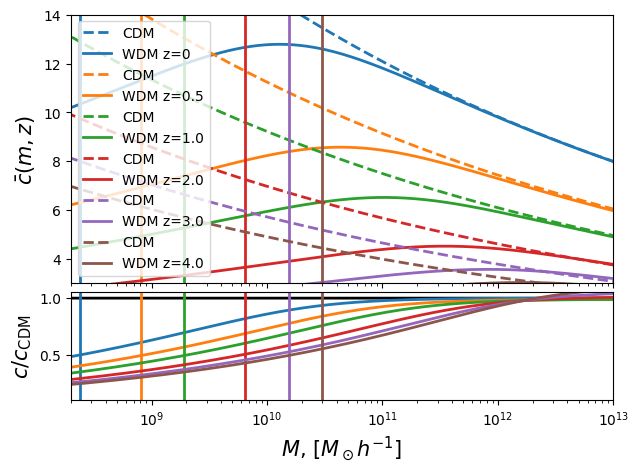

In [10]:
fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    subplot_kw={"xscale": "log", "xlim": (3e7, 3e14)},
    gridspec_kw={"height_ratios": [2.5, 1], "hspace": 0.05},
    figsize=(7, 5),
)

ax[1].plot(cdm.m, np.ones_like(cdm.m), color="k", lw=2)

wdm.update(wdm_mass=3.3)

for i, z in enumerate([0, 0.5, 1.0, 2.0, 3.0, 4.0]):
    wdm.update(z=z)
    cdm.update(z=z)

    ax[0].plot(cdm.m, cdm.cmz_relation, label="CDM", color=f"C{i}", ls="--", lw=2)

    ax[0].plot(wdm.m, wdm.cmz_relation, label=f"WDM z={z}", color=f"C{i}", lw=2)
    ax[1].plot(wdm.m, wdm.cmz_relation / cdm.cmz_relation, color=f"C{i}", lw=2)
    ax[0].axvline(wdm.wdm.m_hm, color=f"C{i}", lw=2)
    ax[1].axvline(wdm.wdm.m_hm, color=f"C{i}", lw=2)
ax[1].set_xlabel(r"$M$, $[M_\odot h^{-1}]$", fontsize=15)
ax[0].set_ylabel(r"$\bar{c}(m,z)$", fontsize=15)
ax[1].set_ylabel(r"$c/c_{\rm CDM}$", fontsize=15)
ax[0].legend(loc=0)
ax[1].set_ylim((0.1, 1.05))
ax[0].set_ylim((3, 14))
ax[0].set_xlim((2e8, 1e13))

Compare this to Bose+15: <img src="bose_cm.jpg">

They won't be exactly the same because almost certainly the CDM $c(m)$ relation is slightly different. 

Alternatively, we can use the form from Ludlow+16, which is explored better in the ludlow_concentration_tests notebook. We merely re-form the plot here to put in the paper. This is with an Einasto profile.

/home/sgm/work/halos/halomod/.venv/lib/python3.12/site-packages/hmf/mass_function/hmf.py:299: UserWarning: Your input mass definition 'SOCritical(200)' does not match the mass definition in which the hmf fit SMT was measured:'SOVirial'. The mass function will be converted to your input definition, but note that some properties do not survive the conversion, eg. the integral of the hmf over mass yielding the total mean density.
  warnings.warn(


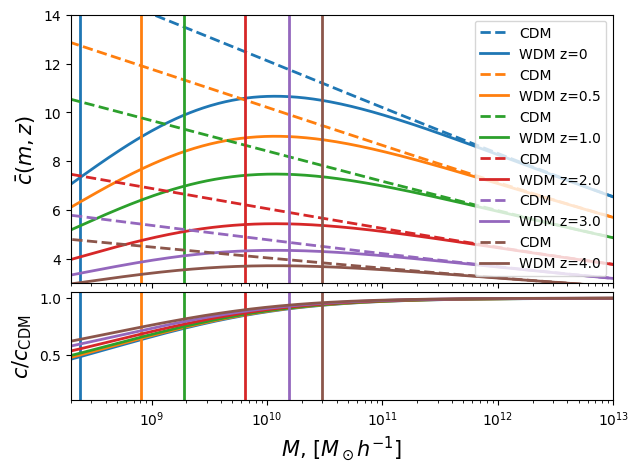

In [11]:
wdm = HaloModelWDM(
    hmf_model="SMT",
    z=0,
    hmf_params={"a": 1},
    filter_model="TopHat",
    mdef_model="SOCritical",
    halo_concentration_model="Ludlow16",
    halo_profile_model="Einasto",
    wdm_mass=3.3,
    Mmin=7.0,
    disable_mass_conversion=False,
)
cdm = DMHaloModel(
    hmf_model="SMT",
    z=0,
    hmf_params={"a": 1},
    filter_model="TopHat",
    halo_concentration_model="Ludlow16",
    halo_profile_model="Einasto",
    Mmin=7.0,
    mdef_model="SOCritical",
    disable_mass_conversion=False,
)

fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    subplot_kw={"xscale": "log", "xlim": (3e7, 3e14)},
    gridspec_kw={"height_ratios": [2.5, 1], "hspace": 0.05},
    figsize=(7, 5),
)

wdm.update(wdm_mass=3.3)

for i, z in enumerate([0, 0.5, 1.0, 2.0, 3.0, 4.0]):
    wdm.update(z=z)
    cdm.update(z=z)

    ax[0].plot(cdm.m, cdm.cmz_relation, label="CDM", color=f"C{i}", ls="--", lw=2)

    ax[0].plot(wdm.m, wdm.cmz_relation, label=f"WDM z={z}", color=f"C{i}", lw=2)
    ax[1].plot(wdm.m, wdm.cmz_relation / cdm.cmz_relation, color=f"C{i}", lw=2)
    ax[0].axvline(wdm.wdm.m_hm, color=f"C{i}", lw=2)
    ax[1].axvline(wdm.wdm.m_hm, color=f"C{i}", lw=2)
ax[1].set_xlabel(r"$M$, $[M_\odot h^{-1}]$", fontsize=15)
ax[0].set_ylabel(r"$\bar{c}(m,z)$", fontsize=15)
ax[1].set_ylabel(r"$c/c_{\rm CDM}$", fontsize=15)
ax[0].legend(loc=0)
ax[1].set_ylim((0.1, 1.05))
ax[0].set_ylim((3, 14))
ax[0].set_xlim((2e8, 1e13));

## Framework

Here we assume that the normal framework for $P_{1h}(k)$ and $P_{2h}(k)$ are known in CDM. Then, as the formulation of Schneider goes, we introduce a smooth component of mass which does not exist inside halos, at scales below the free-streaming length. Then the total power is

$$ P(k) = (1-f)^2 P_{ss}(k) + 2(1-f)f P_{sh}(k) + f^2 P_{hh}(k),$$

where $f$ is the fraction of mass in halos:

$$ f = \frac{1}{\bar{\rho}} \int m n(m) dm, $$

We have $P_{hh}(k) = P_{1h}(k) + P_{2h}(k)$ as usual.

Also, the halo-smooth power is basically the same as the two-halo term, but not squared. In detail, this is

$$ P_{sh}(k) = \frac{1}{\bar{\rho}_h} \int dm n(m) m u(k|m) P^c_{hs}(k|m), $$

where $P^c_{hs}(k|m)$ is the power spectrum of halo centres with respect to the smooth field. This reduces to 

$$ P^c_{sh}(k|m) \sim b_s b(m) P_{lin}(k). $$

Note that there should be some exclusion modelling here as well, but it clearly differs from halo-halo exclusion. We follow Schneider for now and leave that out, but it should be done in the future.

And finally the smooth-smooth power is merely

$$ P_{ss} = b_s^2 P_{lin}(k). $$


We have $b_s$ defined by

$$ b_s = \frac{1-fb_{eff}}{1-f}, $$

where $b_{eff}$ is the effective large-scale halo bias,

$$ b_{eff} = \frac{1}{\bar{\rho}} \int m n(m) b(m) dm. $$ 

The smooth bias is always less than 1, so is technically an antibias.

In [12]:
cdm.update(
    exclusion_model=None,
    hc_spectrum="linear",
    sd_bias_model=None,
    takahashi=False,
    Mmin=2,
    halo_profile_model="NFW",
    halo_concentration_model="Bullock01Power",
    hmf_params={"a": 0.707},
    mdef_model="FOF",
    z=0,
    hmf_model="SMT",
)

wdm.update(
    exclusion_model=None,
    hc_spectrum="linear",
    sd_bias_model=None,
    takahashi=False,
    Mmin=2,
    halo_profile_model="NFW",
    halo_concentration_model="Bullock01Power",
    hmf_params={"a": 0.707},
    mdef_model="FOF",
    z=0,
    hmf_model="SMT",
    wdm_mass=3,
)

/home/sgm/work/halos/halomod/.venv/lib/python3.12/site-packages/hmf/mass_function/hmf.py:299: UserWarning: Your input mass definition 'FoF(l=0.2)' does not match the mass definition in which the hmf fit SMT was measured:'SOVirial'. The mass function will be converted to your input definition, but note that some properties do not survive the conversion, eg. the integral of the hmf over mass yielding the total mean density.
  warnings.warn(


/home/sgm/work/halos/halomod/src/halomod/halo_model.py:384: UserWarning: Requested mass definition 'FoF(l=0.2)' is not in native definitions for the 'Bullock01Power' CMRelation. No mass conversion will be performed, so results will be wrong. Using 'FoF(l=0.2)'.
  return self.halo_concentration_model(
/home/sgm/work/halos/halomod/src/halomod/halo_model.py:830: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


(0.6, 40000.0)

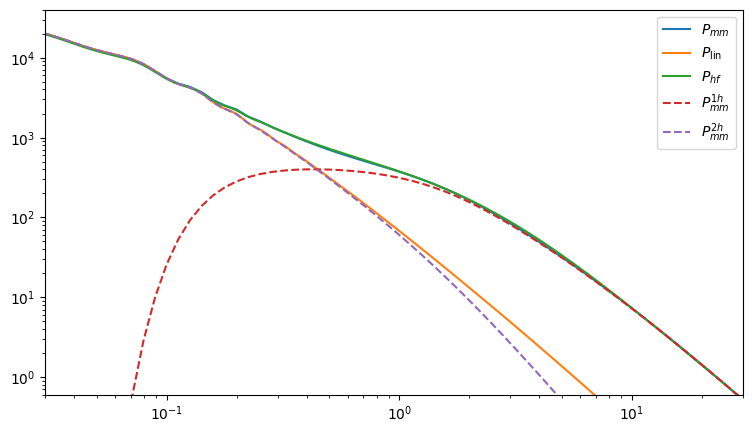

In [13]:
plt.figure(figsize=(9, 5))
plt.plot(cdm.k_hm, cdm.power_auto_matter, label=r"$P_{mm}$")
plt.plot(cdm.k, cdm.power, label=r"$P_{\rm lin}$")
plt.plot(cdm.k, cdm.nonlinear_power, label=r"$P_{hf}$")
plt.plot(cdm.k_hm, cdm.power_1h_auto_matter, ls="--", label=r"$P_{mm}^{1h}$")
plt.plot(cdm.k_hm, cdm.power_2h_auto_matter, ls="--", label=r"$P_{mm}^{2h}$")

plt.legend(loc=0)
plt.xscale("log")
plt.yscale("log")
plt.xlim((0.03, 30.0))
plt.ylim((6e-1, 4e4))

(0.6, 40000.0)

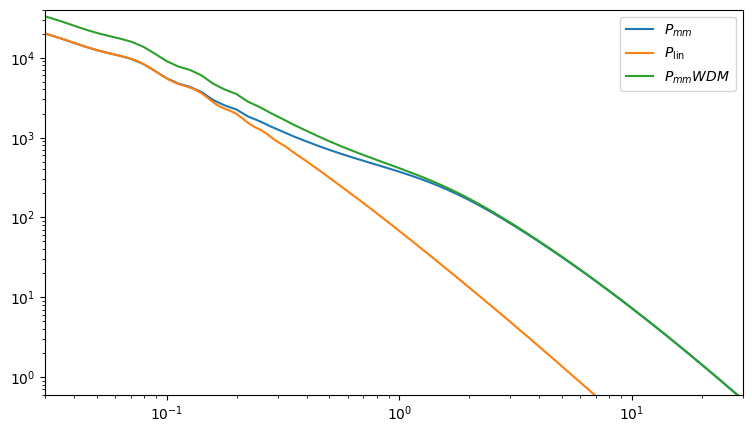

In [14]:
plt.figure(figsize=(9, 5))
plt.plot(cdm.k_hm, cdm.power_auto_matter, label=r"$P_{mm}$")
plt.plot(cdm.k, cdm.power, label=r"$P_{\rm lin}$")
plt.plot(cdm.k_hm, wdm.power_auto_matter, label=r"$P_{mm} WDM$")


plt.legend(loc=0)
plt.xscale("log")
plt.yscale("log")
plt.xlim((0.03, 30.0))
plt.ylim((6e-1, 4e4))

(0.6, 40000.0)

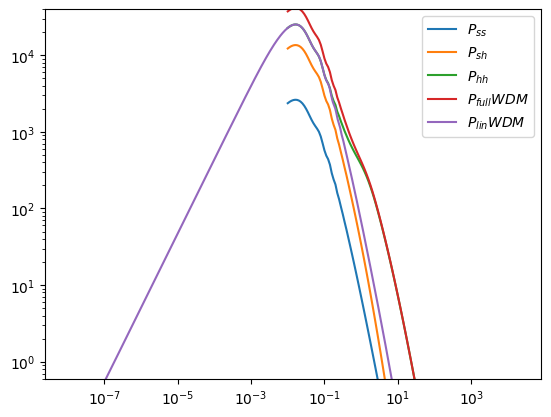

In [15]:
plt.plot(cdm.k_hm, (1 - wdm.f_halos) ** 2 * wdm.power_auto_matter_ss, label=r"$P_{ss}$")
plt.plot(
    cdm.k_hm, 2 * (1 - wdm.f_halos) * wdm.f_halos * wdm.power_auto_matter_sh, label=r"$P_{sh}$"
)
plt.plot(cdm.k_hm, wdm.f_halos**2 * wdm.power_auto_matter_hh, label=r"$P_{hh}$")
plt.plot(cdm.k_hm, wdm.power_auto_matter, label=r"$P_{full} WDM$")
plt.plot(cdm.k, wdm.power, label=r"$P_{lin} WDM$")
# plot(cdm.k, wdm._power_halo_centres, label=r'P_{hc}')

plt.legend(loc=0)
plt.xscale("log")
plt.yscale("log")
# xlim((0.03,30.0))
plt.ylim((6e-1, 4e4))

### For Galaxies

For  galaxies, there is no smooth component. We still expect the galaxies to physically form in haloes. The total galaxy density is just defined by the lower limit $M_{min}$ still. So, really, we can bypass the whole framework infrastructure of the dark matter. Also, we really just want to work with the correlation function, which is what we actually measure with galaxy surveys.

We first plot the pure CDM case, with parameters from Beutler+13

In [16]:
cdm = HaloModel(
    sd_bias_model="TinkerSD05",
    takahashi=True,
    hmf_model="SMT",
    z=0,
    hmf_params={"a": 1},
    filter_model="SharpK",
    filter_params={"c": 2.5},
    halo_concentration_model="Duffy08",
    hod_model="Zehavi05",
    hod_params={"alpha": 1.214, "M_1": 13.396, "M_min": 12.0478},
    hc_spectrum="nonlinear",
)

wdm = TracerHaloModelWDM(
    sd_bias_model="TinkerSD05",
    takahashi=True,
    hmf_model="SMT",
    z=0,
    hmf_params={"a": 1},
    filter_model="SharpK",
    filter_params={"c": 2.5},
    halo_concentration_model="Duffy08",
    hod_model="Zehavi05",
    hod_params={"alpha": 1.214, "M_1": 13.396, "M_min": 12.0478},
    hc_spectrum="nonlinear",
    wdm_mass=0.1,
)

: 

We have nothing to explicitly compare to in the case of WDM, but we can check that it does the right kind of thing:

In [17]:
wdm.update(wdm_mass=1000.0)

fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    subplot_kw={"xscale": "log"},
    gridspec_kw={"height_ratios": [2.5, 1], "hspace": 0.05},
    figsize=(7, 7),
)

ax[0].plot(cdm.r, cdm.corr_auto_tracer, label="CDM", color="b")
ax[1].plot(cdm.r, np.ones_like(cdm.r), color="b")

ax[0].plot(wdm.r, wdm.corr_auto_tracer, label="WDM (1000 keV)", color="g")
ax[1].plot(wdm.r, wdm.corr_auto_tracer / cdm.corr_auto_tracer, color="g")

ax[1].set_xlabel(r"$r [Mpc/h]$")
ax[0].set_ylabel(r"$\xi(r)$")
ax[1].set_ylabel(r"$\xi(r)/\xi_{CDM}(r)$")
ax[0].legend(loc=0)
ax[0].set_yscale("log")

We really should not see much of a difference unless $m_{hm} > M_{min}$, so let's use $m_{hm} = 10^{10}$, just below the $M_{min}$ we have set here. This corresponds roughly to $m_x = 1.0$.

1.27545217679


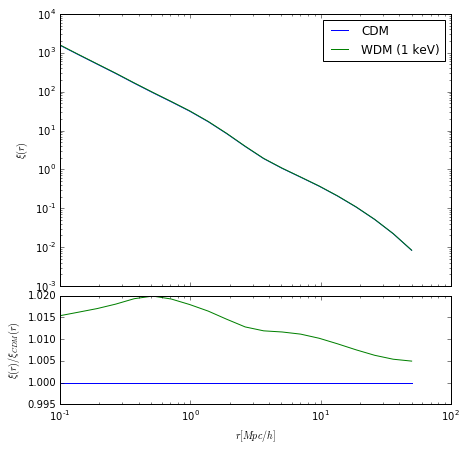

In [ ]:
wdm.update(wdm_mass=1.0)
fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    subplot_kw={"xscale": "log"},
    gridspec_kw={"height_ratios": [2.5, 1], "hspace": 0.05},
    figsize=(7, 7),
)

ax[0].plot(cdm.r, cdm.corr_auto_tracer, label="CDM", color="b")
ax[1].plot(cdm.r, np.ones_like(cdm.r), color="b")

ax[0].plot(wdm.r, wdm.corr_auto_tracer, label="WDM (1 keV)", color="g")
ax[1].plot(wdm.r, wdm.corr_auto_tracer / cdm.corr_auto_tracer, color="g")

ax[1].set_xlabel(r"$r [Mpc/h]$")
ax[0].set_ylabel(r"$\xi(r)$")
ax[1].set_ylabel(r"$\xi(r)/\xi_{CDM}(r)$")
ax[0].legend(loc=0)
ax[0].set_yscale("log")

Here we see that there's only a ~1% shift, with a very similar shape to before. If we decrease the particle mass more however:

2726.86840094


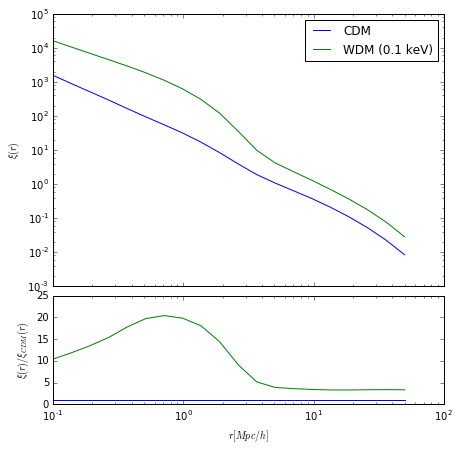

In [ ]:
wdm.update(wdm_mass=0.1)
fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    subplot_kw={"xscale": "log"},
    gridspec_kw={"height_ratios": [2.5, 1], "hspace": 0.05},
    figsize=(7, 7),
)

ax[0].plot(cdm.r, cdm.corr_auto_tracer, label="CDM", color="b")
ax[1].plot(cdm.r, np.ones_like(cdm.r), color="b")

ax[0].plot(wdm.r, wdm.corr_auto_tracer, label="WDM (0.1 keV)", color="g")
ax[1].plot(wdm.r, wdm.corr_auto_tracer / cdm.corr_auto_tracer, color="g")

ax[1].set_xlabel(r"$r [Mpc/h]$")
ax[0].set_ylabel(r"$\xi(r)$")
ax[1].set_ylabel(r"$\xi(r)/\xi_{CDM}(r)$")
ax[0].legend(loc=0)
ax[0].set_yscale("log")

The bias in the 1-halo term bias rises indefinitely, while the two-halo term bias rises slower, so a sharper transition is seen. The two-halo term should only ever really see a quasi-linear bias, especially on large scales, and in reality, this will be a single parameter that can be affected by all HOD+WDM parameters.

The intermediate scales are dominated by modelling of the halo exclusion, but we can be confident that this sharp transition should always arise.

The small scale shape can be changed through $\rho(r|m)$ and $\lambda(r|m)$, while the biasing is affected by $n(m)$ and the HOD.

But why does the bias increase with decreasing particle mass? Let's look at really large scales first, where $u(k|m) \rightarrow 1$. Here, we have $\xi_{gg}(r) = b_{eff}^2 \xi_{m}(r)$, where

$$ b_{eff} = \frac{1}{\bar{n}_g}\int_{m_{min}} n(m) b(m) N_t(m) dm. $$

and

$$ \bar{n}_g = \int_{m_{min}} n(m) N_t(m) dm. $$

It would seem that what is happening is that as $m_{hm}$ increases, so that $n(m)$ has higher cut-off, we are more highly weighting the higher masses in the integral, which have higher bias.

So what about the 1-halo term? Find out in a dedicated notebook coming soon...